In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import catboost
pd.set_option('display.max_columns', None)  

In [2]:
train_url = 'http://hackathon.datacrunch.com/data/train_test_hackathon.pkl'
test_url = 'http://hackathon.datacrunch.com/data/hackathon_data.pkl'

train_before = pd.read_pickle(train_url)
test_before = pd.read_pickle(test_url)
train_before.head()

,Feature_1_cv_enum,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14_cv_bool,Feature_15_cv_bool,Feature_16_cv_bool,Feature_17_cv_bool,Feature_18_adv_cv_bool,Feature_19_adv_cv_bool,Feature_20_adv_cv_bool,Feature_21_adv_cv_bool,Feature_22_adv_cv_bool,Feature_23_adv_cv_enum,target_r,target_g,target_b
82247,3.0,387.0,19527.0000,387,0.0000,387,38.699520,2734.620117,-0.189790,0.00,6.149803e+05,0.019819,0,1,0,0,0,0,0,0,0,1,4,1,0,1
143444,3.0,424.0,35489.4999,424,0.0000,424,NaN,NaN,NaN,0.00,4.167333e+06,0.011947,1,1,0,0,0,0,0,0,0,1,4,0,0,0
183844,3.0,253.0,243052.5175,253,0.0000,253,66.548996,2362.719971,0.129491,0.00,1.976974e+07,0.001041,1,1,0,0,0,0,0,0,0,1,4,0,0,0
156433,2.0,1526.0,111029.6685,1526,0.0000,1526,35.044918,2383.120117,0.205257,0.00,5.241259e+06,0.013744,1,0,1,0,0,1,0,0,1,0,0,0,0,0
44639,3.0,50.0,9380.2130,50,15.6942,50,NaN,NaN,NaN,784.71,1.330630e+05,0.005330,1,1,0,0,0,0,0,0,0,1,4,1,1,1


In [5]:
train = train_before.copy()
test = test_before.copy()

for c in train.columns:
    if ("enum" in c):
        dummies = pd.get_dummies(train[c], prefix=c)
        train.drop(columns=[c], inplace=True)
        train = pd.concat([dummies, train], axis=1)

for c in test.columns:
    if ("enum" in c):
        dummies = pd.get_dummies(test[c], prefix=c)
        test.drop(columns=[c], inplace=True)
        test = pd.concat([dummies, test], axis=1)

for c in train.columns:
    train[c] = train[c].fillna(train[c].mean())
    if (not "target" in c):
        test[c] = test[c].fillna(train[c].mean())
        test[c] = test[c].clip(
            train[c].quantile(0.01),
            train[c].quantile(0.99)
        )
    train[c] = train[c].clip(
        train[c].quantile(0.01),
        train[c].quantile(0.99)
    )

In [6]:
train.head()

,Feature_23_adv_cv_enum_0,Feature_23_adv_cv_enum_1,Feature_23_adv_cv_enum_2,Feature_23_adv_cv_enum_3,Feature_23_adv_cv_enum_4,Feature_1_cv_enum_0.0,Feature_1_cv_enum_1.0,Feature_1_cv_enum_2.0,Feature_1_cv_enum_3.0,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14_cv_bool,Feature_15_cv_bool,Feature_16_cv_bool,Feature_17_cv_bool,Feature_18_adv_cv_bool,Feature_19_adv_cv_bool,Feature_20_adv_cv_bool,Feature_21_adv_cv_bool,Feature_22_adv_cv_bool,target_r,target_g,target_b
82247,0,0,0,0,1,0,0,0,1,387.0,19527.0000,387.0,0.0000,387,38.699520,2734.620117,-0.189790,0.00,6.149803e+05,0.019819,0,1,0,0,0,0,0,0,0,1,1,0,1
143444,0,0,0,0,1,0,0,0,1,424.0,35489.4999,424.0,0.0000,424,14907.318483,2519.349161,-0.020086,0.00,4.167333e+06,0.011947,1,1,0,0,0,0,0,0,0,1,0,0,0
183844,0,0,0,0,1,0,0,0,1,253.0,243052.5175,253.0,0.0000,253,66.548996,2362.719971,0.129491,0.00,1.976974e+07,0.001041,1,1,0,0,0,0,0,0,0,1,0,0,0
156433,1,0,0,0,0,0,0,1,0,1526.0,111029.6685,1526.0,0.0000,1526,35.044918,2383.120117,0.205257,0.00,5.241259e+06,0.013744,1,0,1,0,0,1,0,0,1,0,0,0,0
44639,0,0,0,0,1,0,0,0,1,50.0,9380.2130,50.0,15.6942,50,14907.318483,2519.349161,-0.020086,784.71,1.330630e+05,0.005330,1,1,0,0,0,0,0,0,0,1,1,1,1


In [7]:
test.head()

,Feature_23_adv_cv_enum_0,Feature_23_adv_cv_enum_1,Feature_23_adv_cv_enum_2,Feature_23_adv_cv_enum_3,Feature_23_adv_cv_enum_4,Feature_1_cv_enum_0.0,Feature_1_cv_enum_1.0,Feature_1_cv_enum_2.0,Feature_1_cv_enum_3.0,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14_cv_bool,Feature_15_cv_bool,Feature_16_cv_bool,Feature_17_cv_bool,Feature_18_adv_cv_bool,Feature_19_adv_cv_bool,Feature_20_adv_cv_bool,Feature_21_adv_cv_bool,Feature_22_adv_cv_bool
292434,1,0,0,0,0,0,0,1,0,44.0,9997.0,44.0,178.620000,44,174.761581,2859.530029,0.061613,7959.3800,1.912399e+06,0.004401,1,0,1,0,0,1,0,0,0,0
67404,0,0,0,0,1,1,0,0,0,899.0,380533.0,899.0,61.459786,899,79.933372,2673.610107,-0.196754,55252.3473,2.253535e+07,0.002362,1,0,0,1,0,0,0,0,0,1
67050,0,0,0,1,0,0,0,1,0,231.0,12424.0,231.0,9.323000,231,14.218761,2762.129883,-0.341845,2153.6130,1.138826e+05,0.018593,1,0,1,0,0,0,0,0,1,0
205874,0,0,0,1,0,0,0,1,0,9000.0,66381.0,9000.0,0.000000,9000,14.120000,2632.560059,-0.107478,0.0000,1.014965e+06,0.135581,0,0,1,0,0,0,0,0,1,0
102105,0,0,0,0,1,0,0,0,1,1013.0,5266.0,1013.0,0.000000,1013,14907.318483,2519.349161,-0.020086,0.0000,1.371530e+05,0.192366,1,1,0,0,0,0,0,0,0,1


In [48]:
trans = PolynomialFeatures(degree=2)
pca = PCA(n_components=5)
# features = trans.fit_transform(train.drop(columns=['target_r', 'target_g', 'target_b']))
features = pca.fit_transform(train.drop(columns=['target_r', 'target_g', 'target_b']))
# features = train.drop(columns=['target_r', 'target_g', 'target_b'])
# print(pca.explained_variance_ratio_.sum())
print(features.shape)

(300000, 5)


In [49]:
targets = train[['target_r', 'target_g', 'target_b']]
print(targets.shape)

(300000, 3)


In [50]:
def test_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(metrics.classification_report(y_pred, y_test))
    plt.hist(y_pred)
    plt.plot()

In [51]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.05, stratify=targets)

0:	learn: 0.6580449	test: 0.6580037	best: 0.6580037 (0)	total: 67.6ms	remaining: 1m 7s
1:	learn: 0.6346905	test: 0.6346514	best: 0.6346514 (1)	total: 136ms	remaining: 1m 7s
2:	learn: 0.6218861	test: 0.6218488	best: 0.6218488 (2)	total: 205ms	remaining: 1m 8s
3:	learn: 0.6143361	test: 0.6142863	best: 0.6142863 (3)	total: 275ms	remaining: 1m 8s
4:	learn: 0.6109557	test: 0.6109574	best: 0.6109574 (4)	total: 355ms	remaining: 1m 10s
5:	learn: 0.6086320	test: 0.6086812	best: 0.6086812 (5)	total: 443ms	remaining: 1m 13s
6:	learn: 0.6074185	test: 0.6074620	best: 0.6074620 (6)	total: 479ms	remaining: 1m 7s
7:	learn: 0.6060307	test: 0.6060561	best: 0.6060561 (7)	total: 574ms	remaining: 1m 11s
8:	learn: 0.6051590	test: 0.6051363	best: 0.6051363 (8)	total: 664ms	remaining: 1m 13s
9:	learn: 0.6046643	test: 0.6046947	best: 0.6046947 (9)	total: 761ms	remaining: 1m 15s
10:	learn: 0.6042768	test: 0.6043461	best: 0.6043461 (10)	total: 847ms	remaining: 1m 16s
11:	learn: 0.6037323	test: 0.6038009	best: 0.

94:	learn: 0.5971787	test: 0.6004107	best: 0.6004105 (93)	total: 10.3s	remaining: 1m 38s
95:	learn: 0.5971373	test: 0.6004024	best: 0.6004024 (95)	total: 10.4s	remaining: 1m 38s
96:	learn: 0.5970687	test: 0.6003912	best: 0.6003912 (96)	total: 10.5s	remaining: 1m 38s
97:	learn: 0.5970149	test: 0.6003667	best: 0.6003667 (97)	total: 10.7s	remaining: 1m 38s
98:	learn: 0.5969319	test: 0.6003295	best: 0.6003295 (98)	total: 10.8s	remaining: 1m 37s
99:	learn: 0.5968961	test: 0.6002958	best: 0.6002958 (99)	total: 10.9s	remaining: 1m 37s
100:	learn: 0.5968515	test: 0.6002845	best: 0.6002845 (100)	total: 11.1s	remaining: 1m 38s
101:	learn: 0.5968145	test: 0.6002921	best: 0.6002845 (100)	total: 11.2s	remaining: 1m 38s
102:	learn: 0.5967607	test: 0.6002674	best: 0.6002674 (102)	total: 11.4s	remaining: 1m 38s
103:	learn: 0.5967039	test: 0.6002775	best: 0.6002674 (102)	total: 11.5s	remaining: 1m 39s
104:	learn: 0.5966424	test: 0.6002597	best: 0.6002597 (104)	total: 11.6s	remaining: 1m 39s
105:	learn:

186:	learn: 0.5914674	test: 0.5989588	best: 0.5989053 (184)	total: 21.1s	remaining: 1m 31s
187:	learn: 0.5914014	test: 0.5989687	best: 0.5989053 (184)	total: 21.2s	remaining: 1m 31s
188:	learn: 0.5913371	test: 0.5989534	best: 0.5989053 (184)	total: 21.4s	remaining: 1m 31s
189:	learn: 0.5912811	test: 0.5989166	best: 0.5989053 (184)	total: 21.5s	remaining: 1m 31s
190:	learn: 0.5912302	test: 0.5989367	best: 0.5989053 (184)	total: 21.6s	remaining: 1m 31s
191:	learn: 0.5911557	test: 0.5989591	best: 0.5989053 (184)	total: 21.8s	remaining: 1m 31s
192:	learn: 0.5910416	test: 0.5989241	best: 0.5989053 (184)	total: 21.9s	remaining: 1m 31s
193:	learn: 0.5909983	test: 0.5989343	best: 0.5989053 (184)	total: 22s	remaining: 1m 31s
194:	learn: 0.5909292	test: 0.5989214	best: 0.5989053 (184)	total: 22.2s	remaining: 1m 31s
195:	learn: 0.5908777	test: 0.5988943	best: 0.5988943 (195)	total: 22.4s	remaining: 1m 31s
196:	learn: 0.5908051	test: 0.5988355	best: 0.5988355 (196)	total: 22.6s	remaining: 1m 32s
1

279:	learn: 0.5858807	test: 0.5978698	best: 0.5978516 (277)	total: 32.7s	remaining: 1m 24s
280:	learn: 0.5858188	test: 0.5978920	best: 0.5978516 (277)	total: 32.8s	remaining: 1m 23s
281:	learn: 0.5857567	test: 0.5978824	best: 0.5978516 (277)	total: 32.9s	remaining: 1m 23s
282:	learn: 0.5857039	test: 0.5978897	best: 0.5978516 (277)	total: 33s	remaining: 1m 23s
283:	learn: 0.5856460	test: 0.5978651	best: 0.5978516 (277)	total: 33.1s	remaining: 1m 23s
284:	learn: 0.5855932	test: 0.5978387	best: 0.5978387 (284)	total: 33.2s	remaining: 1m 23s
285:	learn: 0.5855330	test: 0.5977841	best: 0.5977841 (285)	total: 33.3s	remaining: 1m 23s
286:	learn: 0.5854573	test: 0.5978072	best: 0.5977841 (285)	total: 33.4s	remaining: 1m 22s
287:	learn: 0.5854053	test: 0.5977808	best: 0.5977808 (287)	total: 33.5s	remaining: 1m 22s
288:	learn: 0.5853632	test: 0.5977636	best: 0.5977636 (288)	total: 33.6s	remaining: 1m 22s
289:	learn: 0.5853116	test: 0.5977451	best: 0.5977451 (289)	total: 33.7s	remaining: 1m 22s
2

370:	learn: 0.5809365	test: 0.5975688	best: 0.5974887 (360)	total: 42.3s	remaining: 1m 11s
371:	learn: 0.5808947	test: 0.5975486	best: 0.5974887 (360)	total: 42.4s	remaining: 1m 11s
372:	learn: 0.5808222	test: 0.5975594	best: 0.5974887 (360)	total: 42.5s	remaining: 1m 11s
373:	learn: 0.5807765	test: 0.5975655	best: 0.5974887 (360)	total: 42.5s	remaining: 1m 11s
374:	learn: 0.5807103	test: 0.5975548	best: 0.5974887 (360)	total: 42.6s	remaining: 1m 11s
375:	learn: 0.5806773	test: 0.5975372	best: 0.5974887 (360)	total: 42.7s	remaining: 1m 10s
376:	learn: 0.5806357	test: 0.5975698	best: 0.5974887 (360)	total: 42.8s	remaining: 1m 10s
377:	learn: 0.5805948	test: 0.5975843	best: 0.5974887 (360)	total: 42.9s	remaining: 1m 10s
378:	learn: 0.5805315	test: 0.5975885	best: 0.5974887 (360)	total: 43s	remaining: 1m 10s
379:	learn: 0.5804944	test: 0.5975600	best: 0.5974887 (360)	total: 43.1s	remaining: 1m 10s
380:	learn: 0.5804065	test: 0.5974813	best: 0.5974813 (380)	total: 43.1s	remaining: 1m 10s
3

462:	learn: 0.5762912	test: 0.5972513	best: 0.5970892 (422)	total: 51.2s	remaining: 59.3s
463:	learn: 0.5762296	test: 0.5972701	best: 0.5970892 (422)	total: 51.3s	remaining: 59.2s
464:	learn: 0.5761752	test: 0.5972722	best: 0.5970892 (422)	total: 51.3s	remaining: 59.1s
465:	learn: 0.5761385	test: 0.5972604	best: 0.5970892 (422)	total: 51.4s	remaining: 59s
466:	learn: 0.5760767	test: 0.5972439	best: 0.5970892 (422)	total: 51.5s	remaining: 58.8s
467:	learn: 0.5760240	test: 0.5972698	best: 0.5970892 (422)	total: 51.6s	remaining: 58.7s
468:	learn: 0.5759699	test: 0.5972950	best: 0.5970892 (422)	total: 51.7s	remaining: 58.6s
469:	learn: 0.5759203	test: 0.5972993	best: 0.5970892 (422)	total: 51.8s	remaining: 58.4s
470:	learn: 0.5758454	test: 0.5972652	best: 0.5970892 (422)	total: 51.9s	remaining: 58.3s
471:	learn: 0.5757770	test: 0.5972596	best: 0.5970892 (422)	total: 52s	remaining: 58.2s
472:	learn: 0.5757366	test: 0.5972820	best: 0.5970892 (422)	total: 52.1s	remaining: 58s
473:	learn: 0.57

556:	learn: 0.5716813	test: 0.5970786	best: 0.5970786 (556)	total: 1m 1s	remaining: 48.8s
557:	learn: 0.5716380	test: 0.5970603	best: 0.5970603 (557)	total: 1m 1s	remaining: 48.6s
558:	learn: 0.5715964	test: 0.5970583	best: 0.5970583 (558)	total: 1m 1s	remaining: 48.5s
559:	learn: 0.5715229	test: 0.5970884	best: 0.5970583 (558)	total: 1m 1s	remaining: 48.4s
560:	learn: 0.5714701	test: 0.5971149	best: 0.5970583 (558)	total: 1m 1s	remaining: 48.2s
561:	learn: 0.5714403	test: 0.5971089	best: 0.5970583 (558)	total: 1m 1s	remaining: 48.1s
562:	learn: 0.5713917	test: 0.5971308	best: 0.5970583 (558)	total: 1m 1s	remaining: 48s
563:	learn: 0.5713371	test: 0.5971010	best: 0.5970583 (558)	total: 1m 1s	remaining: 47.9s
564:	learn: 0.5712576	test: 0.5970649	best: 0.5970583 (558)	total: 1m 2s	remaining: 47.7s
565:	learn: 0.5712027	test: 0.5970503	best: 0.5970503 (565)	total: 1m 2s	remaining: 47.6s
566:	learn: 0.5711692	test: 0.5970267	best: 0.5970267 (566)	total: 1m 2s	remaining: 47.5s
567:	learn: 

649:	learn: 0.5675300	test: 0.5966296	best: 0.5966197 (648)	total: 1m 9s	remaining: 37.6s
650:	learn: 0.5674823	test: 0.5966335	best: 0.5966197 (648)	total: 1m 9s	remaining: 37.5s
651:	learn: 0.5674242	test: 0.5966424	best: 0.5966197 (648)	total: 1m 10s	remaining: 37.4s
652:	learn: 0.5673721	test: 0.5966244	best: 0.5966197 (648)	total: 1m 10s	remaining: 37.3s
653:	learn: 0.5673419	test: 0.5966730	best: 0.5966197 (648)	total: 1m 10s	remaining: 37.2s
654:	learn: 0.5672887	test: 0.5966605	best: 0.5966197 (648)	total: 1m 10s	remaining: 37.1s
655:	learn: 0.5672460	test: 0.5966555	best: 0.5966197 (648)	total: 1m 10s	remaining: 36.9s
656:	learn: 0.5672169	test: 0.5966628	best: 0.5966197 (648)	total: 1m 10s	remaining: 36.8s
657:	learn: 0.5671818	test: 0.5966620	best: 0.5966197 (648)	total: 1m 10s	remaining: 36.7s
658:	learn: 0.5671614	test: 0.5966480	best: 0.5966197 (648)	total: 1m 10s	remaining: 36.6s
659:	learn: 0.5671102	test: 0.5966516	best: 0.5966197 (648)	total: 1m 10s	remaining: 36.5s
6

742:	learn: 0.5639135	test: 0.5965272	best: 0.5964817 (722)	total: 1m 18s	remaining: 27.1s
743:	learn: 0.5638819	test: 0.5965265	best: 0.5964817 (722)	total: 1m 18s	remaining: 27s
744:	learn: 0.5638556	test: 0.5965305	best: 0.5964817 (722)	total: 1m 18s	remaining: 26.9s
745:	learn: 0.5638125	test: 0.5965331	best: 0.5964817 (722)	total: 1m 18s	remaining: 26.8s
746:	learn: 0.5637623	test: 0.5965063	best: 0.5964817 (722)	total: 1m 18s	remaining: 26.6s
747:	learn: 0.5637222	test: 0.5964842	best: 0.5964817 (722)	total: 1m 18s	remaining: 26.5s
748:	learn: 0.5636794	test: 0.5964795	best: 0.5964795 (748)	total: 1m 18s	remaining: 26.4s
749:	learn: 0.5636470	test: 0.5964488	best: 0.5964488 (749)	total: 1m 19s	remaining: 26.3s
750:	learn: 0.5636302	test: 0.5964435	best: 0.5964435 (750)	total: 1m 19s	remaining: 26.2s
751:	learn: 0.5635739	test: 0.5964173	best: 0.5964173 (751)	total: 1m 19s	remaining: 26.1s
752:	learn: 0.5635422	test: 0.5964028	best: 0.5964028 (752)	total: 1m 19s	remaining: 26s
753

833:	learn: 0.5605024	test: 0.5966461	best: 0.5963929 (768)	total: 1m 26s	remaining: 17.3s
834:	learn: 0.5604421	test: 0.5966334	best: 0.5963929 (768)	total: 1m 27s	remaining: 17.2s
835:	learn: 0.5604069	test: 0.5966137	best: 0.5963929 (768)	total: 1m 27s	remaining: 17.1s
836:	learn: 0.5603742	test: 0.5966273	best: 0.5963929 (768)	total: 1m 27s	remaining: 17s
837:	learn: 0.5603463	test: 0.5966102	best: 0.5963929 (768)	total: 1m 27s	remaining: 16.9s
838:	learn: 0.5603099	test: 0.5965948	best: 0.5963929 (768)	total: 1m 27s	remaining: 16.8s
839:	learn: 0.5602779	test: 0.5966101	best: 0.5963929 (768)	total: 1m 27s	remaining: 16.7s
840:	learn: 0.5602082	test: 0.5966066	best: 0.5963929 (768)	total: 1m 27s	remaining: 16.6s
841:	learn: 0.5601855	test: 0.5965857	best: 0.5963929 (768)	total: 1m 27s	remaining: 16.5s
842:	learn: 0.5601558	test: 0.5965903	best: 0.5963929 (768)	total: 1m 27s	remaining: 16.4s
843:	learn: 0.5601144	test: 0.5965792	best: 0.5963929 (768)	total: 1m 28s	remaining: 16.3s
8

926:	learn: 0.5566492	test: 0.5966881	best: 0.5963929 (768)	total: 1m 36s	remaining: 7.62s
927:	learn: 0.5565830	test: 0.5966730	best: 0.5963929 (768)	total: 1m 36s	remaining: 7.52s
928:	learn: 0.5565270	test: 0.5966514	best: 0.5963929 (768)	total: 1m 36s	remaining: 7.41s
929:	learn: 0.5564748	test: 0.5966369	best: 0.5963929 (768)	total: 1m 37s	remaining: 7.31s
930:	learn: 0.5564507	test: 0.5966451	best: 0.5963929 (768)	total: 1m 37s	remaining: 7.2s
931:	learn: 0.5564065	test: 0.5966506	best: 0.5963929 (768)	total: 1m 37s	remaining: 7.1s
932:	learn: 0.5563511	test: 0.5966507	best: 0.5963929 (768)	total: 1m 37s	remaining: 6.99s
933:	learn: 0.5562871	test: 0.5966580	best: 0.5963929 (768)	total: 1m 37s	remaining: 6.89s
934:	learn: 0.5562315	test: 0.5966694	best: 0.5963929 (768)	total: 1m 37s	remaining: 6.78s
935:	learn: 0.5561749	test: 0.5966969	best: 0.5963929 (768)	total: 1m 37s	remaining: 6.68s
936:	learn: 0.5561433	test: 0.5966735	best: 0.5963929 (768)	total: 1m 37s	remaining: 6.57s
9

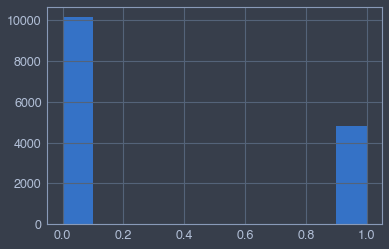

In [54]:
model_r = catboost.CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=10)
model_r.fit(x_train, y_train['target_r'], eval_set=(x_test, y_test['target_r']), verbose=True)
test_model(model_r, x_test, y_test['target_r'])

              precision    recall  f1-score   support

           0       0.76      0.73      0.74    171082
           1       0.61      0.65      0.63    113918

    accuracy                           0.70    285000
   macro avg       0.69      0.69      0.69    285000
weighted avg       0.70      0.70      0.70    285000



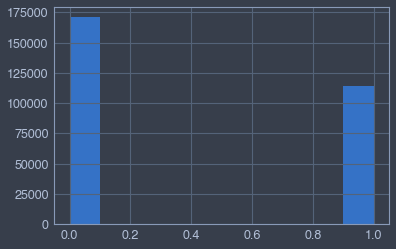

In [19]:
test_model(model_r, x_train, y_train['target_r'])